# Setup

Perform all necessary imports up front

In [ ]:
!pip install --quiet --quiet armory-library armory-examples[huggingface]

In [ ]:
# Python standard imports
from pprint import pprint

# Third-party imports
import torch

# armory-library imports
import armory.engine
import armory.export.image_classification
import armory.evaluation
import armory.utils

# armory-examples imports
import armory.examples.image_classification.food101 as food101
from armory.examples.utils.display import display_image_classification_results

# Define the Evaluation

## Model

From our `food101` example, we will load a model from HuggingFace that has
already been fine-tuned on the food-101 dataset. We also wrap this model in an
Adversarial Robustness Toolbox (ART) estimator so that we can use an ART attack
against the model.

In [ ]:
model, art_estimator = food101.load_model()

## Dataset

From our `food101` example, we will load the food-101 dataset from HuggingFace.

In order to get a variety of classes in this demonstration, we're shuffling the
dataset with a fixed seed.

In [ ]:
torch.manual_seed(8675309)

dataset, labels = food101.load_huggingface_dataset(batch_size=2, shuffle=True)

## Attack

From our `food101` example, we create a Projected Gradient Descent (PGD) attack
using the Adversarial Robustness Toolbox (ART).

In [ ]:
attack = food101.create_pgd_attack(art_estimator)

## Metrics

From our `food101` example, we create the metrics to be collected during the
evaluation. These include an L-infinity norm distance between unperturbed and
perturbed input, and a categorical accuracy between the natural labels and the
predicted labels.

In [ ]:
metrics = food101.create_metrics()

# Evaluation

We combine the model, dataset, attack, and metrics to fully define our
evaluation.

We will define two perturbation chains: `benign` and `attack`. The benign chain
does not apply any perturbations to the data, giving us the intrinsic
performance of the model. The attack chain will give us the performance of the
model under adversarial attack.

We use the image classification exporter to save the benign and perturbed image
samples.

In [ ]:
evaluation = armory.evaluation.Evaluation(
    name="image-classification-food101",
    description="Image classification of food-101",
    author="TwoSix",
    dataset=dataset,
    model=model,
    perturbations={
        "benign": [],
        "attack": [attack],
    },
    metrics=metrics,
    exporter=armory.export.image_classification.ImageClassificationExporter(),
)

# Execute the Evaluation

We create an evaluation engine which will handle the application of all
perturbations, obtaining predictions from the model, collecting metrics, and
exporting of samples.

In [ ]:
engine = armory.engine.EvaluationEngine(
    evaluation,
    export_every_n_batches=1,
    limit_test_batches=2,
)
results = engine.run()

In [ ]:
pprint(results)

{'compute': {},
 'metrics': {'attack/accuracy': tensor(0.),
             'attack/linf_norm': tensor(0.0310),
             'benign/accuracy': tensor(1.),
             'benign/linf_norm': tensor(0.)}}


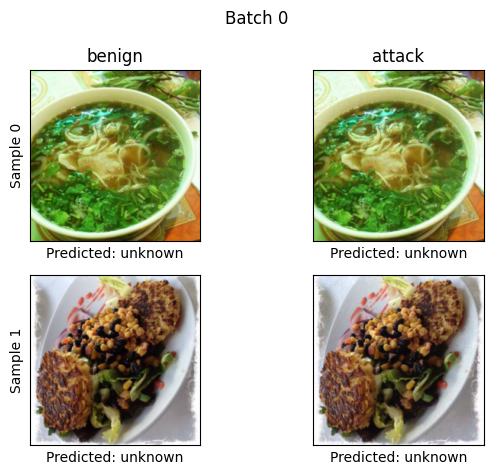

In [ ]:
display_image_classification_results(
    run_id=engine.run_id,
    batch_idx=0,
    batch_size=2,
    chains=["benign", "attack"],
    labels=labels,
)

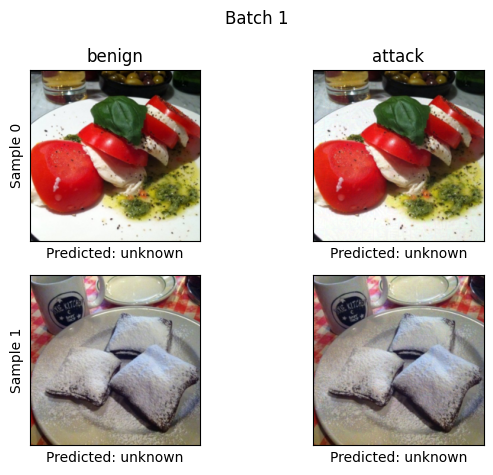

In [ ]:
display_image_classification_results(
    run_id=engine.run_id,
    batch_idx=1,
    batch_size=2,
    chains=["benign", "attack"],
    labels=labels,
)

# Additional Code

In order to make this notebook concise some helper functions have been imported
from [armory.examples.image_classification.food101](https://github.com/twosixlabs/armory-library/blob/master/examples/src/armory/examples/image_classification/food101.py)
